In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time
import os
from tqdm import tqdm

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터셋이 위치한 경로
data_dir = '/content/drive/MyDrive/Parrot DL Project'

In [4]:
# 이미지 변환
data_transforms = {
    'train': transforms.Compose([ # 원본 이미지 그대로
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# 이미지 데이터셋 불러오기
full_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])

# 클래스명
class_names = full_dataset.classes

In [6]:
## 증강한 데이터셋
augmented_dataset = datasets.ImageFolder(os.path.join(data_dir, 'augmented'),
                                          data_transforms['train'])
class_names_aug = augmented_dataset.classes

In [7]:
type(full_dataset), len(full_dataset), type(augmented_dataset), len(augmented_dataset)

(torchvision.datasets.folder.ImageFolder,
 10597,
 torchvision.datasets.folder.ImageFolder,
 10597)

In [8]:
len(class_names), class_names[:10]

(200,
 ['001.Black_footed_Albatross',
  '002.Laysan_Albatross',
  '003.Sooty_Albatross',
  '004.Groove_billed_Ani',
  '005.Crested_Auklet',
  '006.Least_Auklet',
  '007.Parakeet_Auklet',
  '008.Rhinoceros_Auklet',
  '009.Brewer_Blackbird',
  '010.Red_winged_Blackbird'])

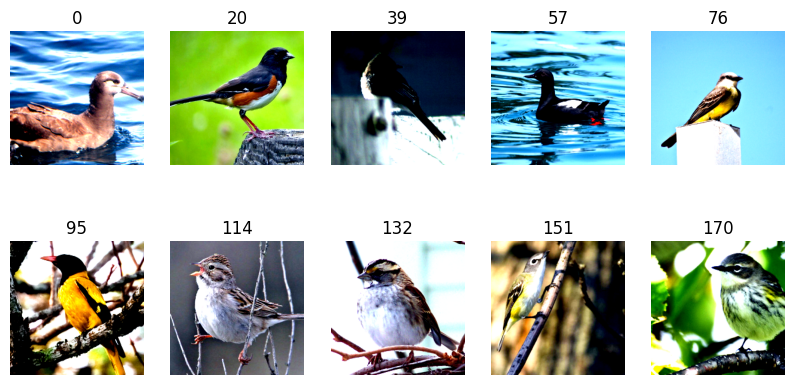

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))

cnt = 1
for i in range(0, 10000, 1000):
  image, label = full_dataset[i]
  image = np.transpose(image, (1, 2, 0)) # (3, 224, 224) --> (224, 224, 3)
  image = image / 2 + 0.5  # [0, 1] 범위로 정규화

  plt.subplot(2, 5, cnt)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  cnt += 1

plt.show() # 원본 이미지 시각화

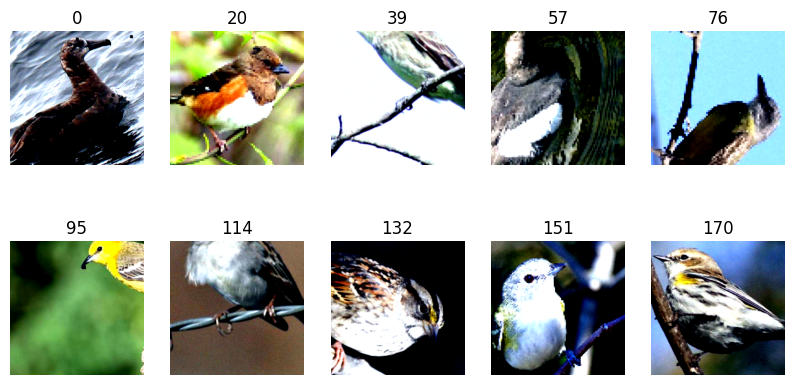

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))

cnt = 1
for i in range(0, 10000, 1000):
  image, label = augmented_dataset[i]
  image = np.transpose(image, (1, 2, 0)) # (3, 224, 224) --> (224, 224, 3)
  image = image / 2 + 0.5  # [0, 1] 범위로 정규화

  plt.subplot(2, 5, cnt)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  cnt += 1

plt.show() # 증강된 이미지 시각화

In [11]:
from torch.utils.data import ConcatDataset

# 데이터셋을 train과 valid로 나누기
origin_train_size = int(0.7 * len(full_dataset))
valid_size = len(full_dataset) - origin_train_size
origin_train_dataset, valid_dataset = random_split(full_dataset, [origin_train_size, valid_size])

# augmented를 origin_train에 더해서 train_dataset을 만든다
train_dataset = ConcatDataset([origin_train_dataset, augmented_dataset])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print(len(train_dataset), valid_size)
print(train_dataset[0][0].shape)

18014 3180
torch.Size([3, 224, 224])


In [12]:
# GPU 사용 가능 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3c5811ff7362809682bd5e84c3452f99afaf2115eeefe8701ca9f495b9a536d8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [14]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

class EfficientNetCustom(nn.Module):
    def __init__(self, freeze=False):
        super(EfficientNetCustom, self).__init__()
        self.pretrained_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

        if freeze:
            for param in self.pretrained_efficientnet.parameters():
                param.requires_grad = False

        # 예측에 사용되는 EfficientNet의 마지막 계층들을 새로이 정의
        self.pretrained_efficientnet._fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 200)
        )

    def forward(self, input):
        return self.pretrained_efficientnet(input)

# 모델 생성 및 장치로 이동
model = EfficientNetCustom(freeze=False).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 373MB/s]


Loaded pretrained weights for efficientnet-b0


In [15]:
from torchsummary import summary
summary(model, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 245, 245]               0
Conv2dStaticSamePadding-2         [-1, 32, 122, 122]             864
       BatchNorm2d-3         [-1, 32, 122, 122]              64
MemoryEfficientSwish-4         [-1, 32, 122, 122]               0
         ZeroPad2d-5         [-1, 32, 124, 124]               0
Conv2dStaticSamePadding-6         [-1, 32, 122, 122]             288
       BatchNorm2d-7         [-1, 32, 122, 122]              64
MemoryEfficientSwish-8         [-1, 32, 122, 122]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [16]:
print(model)

EfficientNetCustom(
  (pretrained_efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): 

In [17]:
# 손실함수 설정
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)

# Optimizer 설정
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Scheduler 설정
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [18]:
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

def train_val(num_epochs):
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)
      for phase in ['train', 'valid']:
          if phase == 'train':
              dataloader = train_loader
              model.train()
          else:
              dataloader = valid_loader
              model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in tqdm(dataloader):
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              step_lr_scheduler.step()

          epoch_loss = running_loss / len(dataloader.dataset)
          epoch_acc = running_corrects.double() / len(dataloader.dataset)
          if phase == 'train':
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc.cpu().numpy())
          else:
            valid_loss_list.append(epoch_loss)
            valid_acc_list.append(epoch_acc.cpu().numpy())

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

In [20]:
train_val(10)

Epoch 1/10
----------


100%|██████████| 563/563 [05:37<00:00,  1.67it/s]


train Loss: 4.2848 Acc: 0.1799


100%|██████████| 100/100 [42:09<00:00, 25.30s/it]


valid Loss: 3.5102 Acc: 0.4792
Epoch 2/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.64it/s]


train Loss: 3.6210 Acc: 0.3394


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


valid Loss: 3.0147 Acc: 0.6211
Epoch 3/10
----------


100%|██████████| 563/563 [03:34<00:00,  2.63it/s]


train Loss: 3.2647 Acc: 0.4592


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


valid Loss: 2.7181 Acc: 0.7038
Epoch 4/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 3.0197 Acc: 0.5517


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


valid Loss: 2.5523 Acc: 0.7528
Epoch 5/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 2.8321 Acc: 0.6223


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


valid Loss: 2.4381 Acc: 0.7799
Epoch 6/10
----------


100%|██████████| 563/563 [03:35<00:00,  2.61it/s]


train Loss: 2.7016 Acc: 0.6760


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


valid Loss: 2.3709 Acc: 0.7899
Epoch 7/10
----------


100%|██████████| 563/563 [03:35<00:00,  2.61it/s]


train Loss: 2.6040 Acc: 0.7065


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


valid Loss: 2.3233 Acc: 0.8016
Epoch 8/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 2.5276 Acc: 0.7387


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


valid Loss: 2.2851 Acc: 0.8116
Epoch 9/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.64it/s]


train Loss: 2.4548 Acc: 0.7701


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


valid Loss: 2.2495 Acc: 0.8189
Epoch 10/10
----------


100%|██████████| 563/563 [03:32<00:00,  2.65it/s]


train Loss: 2.3979 Acc: 0.7883


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]

valid Loss: 2.2236 Acc: 0.8267


In [21]:
train_val(10)

Epoch 1/10
----------


100%|██████████| 563/563 [03:34<00:00,  2.62it/s]


train Loss: 2.3381 Acc: 0.8123


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


valid Loss: 2.1973 Acc: 0.8346
Epoch 2/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.64it/s]


train Loss: 2.3003 Acc: 0.8241


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


valid Loss: 2.1813 Acc: 0.8349
Epoch 3/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.64it/s]


train Loss: 2.2622 Acc: 0.8417


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


valid Loss: 2.1686 Acc: 0.8387
Epoch 4/10
----------


100%|██████████| 563/563 [03:32<00:00,  2.65it/s]


train Loss: 2.2280 Acc: 0.8518


100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


valid Loss: 2.1512 Acc: 0.8399
Epoch 5/10
----------


100%|██████████| 563/563 [03:32<00:00,  2.65it/s]


train Loss: 2.1983 Acc: 0.8664


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


valid Loss: 2.1357 Acc: 0.8450
Epoch 6/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.64it/s]


train Loss: 2.1726 Acc: 0.8747


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


valid Loss: 2.1253 Acc: 0.8484
Epoch 7/10
----------


100%|██████████| 563/563 [03:34<00:00,  2.62it/s]


train Loss: 2.1510 Acc: 0.8824


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


valid Loss: 2.1241 Acc: 0.8481
Epoch 8/10
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 2.1249 Acc: 0.8954


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


valid Loss: 2.1075 Acc: 0.8528
Epoch 9/10
----------


100%|██████████| 563/563 [03:34<00:00,  2.63it/s]


train Loss: 2.1059 Acc: 0.8994


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


valid Loss: 2.1020 Acc: 0.8535
Epoch 10/10
----------


100%|██████████| 563/563 [03:34<00:00,  2.63it/s]


train Loss: 2.0903 Acc: 0.9058


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]

valid Loss: 2.0947 Acc: 0.8544


In [24]:
train_val(5)

Epoch 1/5
----------


100%|██████████| 563/563 [03:35<00:00,  2.62it/s]


train Loss: 2.0717 Acc: 0.9142


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


valid Loss: 2.0911 Acc: 0.8601
Epoch 2/5
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 2.0603 Acc: 0.9168


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


valid Loss: 2.0842 Acc: 0.8604
Epoch 3/5
----------


100%|██████████| 563/563 [03:34<00:00,  2.63it/s]


train Loss: 2.0523 Acc: 0.9206


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


valid Loss: 2.0834 Acc: 0.8610
Epoch 4/5
----------


100%|██████████| 563/563 [03:34<00:00,  2.62it/s]


train Loss: 2.0434 Acc: 0.9217


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


valid Loss: 2.0769 Acc: 0.8638
Epoch 5/5
----------


100%|██████████| 563/563 [03:34<00:00,  2.62it/s]


train Loss: 2.0289 Acc: 0.9291


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

valid Loss: 2.0744 Acc: 0.8610


In [25]:
train_val(5)

Epoch 1/5
----------


100%|██████████| 563/563 [03:35<00:00,  2.62it/s]


train Loss: 2.0134 Acc: 0.9352


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


valid Loss: 2.0694 Acc: 0.8604
Epoch 2/5
----------


100%|██████████| 563/563 [03:35<00:00,  2.61it/s]


train Loss: 2.0043 Acc: 0.9384


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


valid Loss: 2.0654 Acc: 0.8626
Epoch 3/5
----------


100%|██████████| 563/563 [03:35<00:00,  2.61it/s]


train Loss: 2.0009 Acc: 0.9380


100%|██████████| 100/100 [00:26<00:00,  3.84it/s]


valid Loss: 2.0630 Acc: 0.8654
Epoch 4/5
----------


100%|██████████| 563/563 [03:36<00:00,  2.61it/s]


train Loss: 1.9869 Acc: 0.9435


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


valid Loss: 2.0596 Acc: 0.8635
Epoch 5/5
----------


100%|██████████| 563/563 [03:33<00:00,  2.63it/s]


train Loss: 1.9870 Acc: 0.9454


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]

valid Loss: 2.0537 Acc: 0.8654


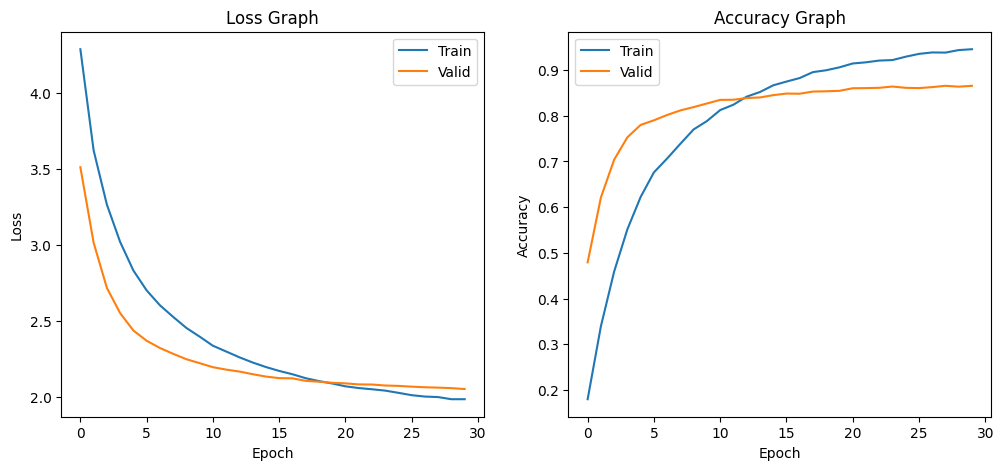

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train')
plt.plot(valid_loss_list, label='Valid')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train')
plt.plot(valid_acc_list, label='Valid')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend()

plt.show()

In [27]:
# save the model
PATH = './'
torch.save(model, PATH + 'model.pth')